# 多模态模型搭建
## 1.数据准备
### 1.1数据整合
### 1.2数据增强
## 2.模型搭建
## 3.模型对比

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import time
import jieba
import random
import json
import ast
import os
from torchvision import transforms
from PIL import Image
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
meta=['merged_sales_category','price','shipping_insurance','free_shipping','city','product_discrip', 'mkt_service', 'mailing','图案', '领型', '袖型', '填充物', '细分风格',
       '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '穿搭方式','上市年份季节', '销售渠道类型','size_count', 'color_count']
Descrip=['name','words']
Pic=['num']

In [3]:
df=pd.read_csv('broaden_data.csv')
df=df.query('src_list.notna()')[meta+Descrip+Pic]

### 数据整合

In [4]:
# 对于每个类别型列
category_columns = ['图案', '领型', '袖型', '填充物', '细分风格', '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '穿搭方式', '上市年份季节', '销售渠道类型']

# 使用循环处理每一列
for col in category_columns:
    df[col] = df[col].fillna('Unknown')
    
for col in ['product_discrip', 'mkt_service', 'mailing','size_count','color_count']:
    df[col] = df[col].fillna(df[col].median())

In [5]:
df['shipping_insurance'] = df['shipping_insurance'].astype(int)
df['free_shipping'] = df['free_shipping'].astype(int)
df['words']=df['words'].apply(ast.literal_eval)

In [6]:
df['merged_sales_category'].value_counts()

small    1898
mid      1519
high      120
Name: merged_sales_category, dtype: int64

### 数据增强

In [7]:
def data_aug(df, label_aug=[], num_aug=[], meta_columns=[], synonyms_dic_name="",
             text_aug_prob=0.5, meta_aug_prob=0.5, image_aug_prob=0.5):
    '''
    df: augmented data
    label_aug:labels you want to aug
    num_aug: the number you want to aug to 
    meta_columns: indicate which columns are meta data
    synonyms_dic_name:synonyms dictionary's name
    '''
    #增强策略：抽取一些数据然后随机对文本、元数据、图片三部分进行变换，变换哪部分也是随机的可以同时变换三种数据也可以同时
    
    #抽取要增加的行: 抽取策略是对于某个标签来说如果要增加的数据量大于已有的数据量那么允许重复抽样，反之则不允许
    
    #文本增强策略：近义词替换
    
    #元数据增强：过采样
    
    #图片增强：生成标记"pic_auged"然后准备交给下一步处理
    
    #新增总体标记行"is_auged"
    
    #和df合并并填补空隙
    
    
    # 加载近义词词典
    synonym_dict = {}
    if synonyms_dic_name:
        with open(synonyms_dic_name, 'r', encoding='utf-8') as file:
            synonym_dict = json.load(file)

    # 创建一个空的DataFrame以保存增强后的数据
    df_auged = pd.DataFrame()

    for index,label in enumerate(label_aug):
        df_label = df[df['merged_sales_category'] == label]
        aug_count = num_aug[index] 

        if aug_count -len(df_label)> 0:
            df_sample = df_label.sample(aug_count, replace=True)
        else:
            df_sample = df_label.sample(aug_count, replace=False)
        
        # 对每行数据进行增强
        for idx, row in df_sample.iterrows():
            new_row = row.copy()

            # 文本增强
            if 'words' in row and random.random() < text_aug_prob:
                words = row['words']
                num_to_replace = int(len(words) * 0.5)
                words_to_replace = random.sample(words, num_to_replace)
                
                new_words = words.copy()
                for word in words_to_replace:
                    if word in synonym_dict:
                        synonym = random.choice(synonym_dict[word])
                        new_words = [synonym if w == word else w for w in new_words]
                
                new_row['words'] = new_words
                #合并

            # 元数据增强
            if random.random() < meta_aug_prob:
                for meta_col in meta_columns:
                    if pd.api.types.is_numeric_dtype(df[meta_col]):
                        # 对数值型变量增加随机数
                        new_row[meta_col] = row[meta_col] + np.random.normal(-0.1, 0.1)
                    # 如果是分类变量，则不变化


            # 图片增强标记
            if random.random() < image_aug_prob:
                new_row['pic_auged'] = True


            # 总体标记
            new_row['is_auged'] = True

            # 将新行添加到增强数据集
            df_auged = df_auged.append(new_row)

    # 合并原始数据和增强数据
    
    df_auged = pd.concat([df, df_auged])
    df_auged['is_auged'].fillna(0, inplace=True)
    df_auged['pic_auged'].fillna(0, inplace=True)


    return df_auged

In [8]:
df_auged=data_aug(df, label_aug=['high',"mid","small"], num_aug=[800,500,500], meta_columns=['price', 'product_discrip', 'mkt_service', 'mailing'], synonyms_dic_name="synonyms_expanded_narrow.json",text_aug_prob=0.5, meta_aug_prob=0.5, image_aug_prob=0.5)

In [182]:
df_auged.head()

,merged_sales_category,price,shipping_insurance,free_shipping,city,product_discrip,mkt_service,mailing,图案,领型,...,穿搭方式,上市年份季节,销售渠道类型,size_count,color_count,name,words,num,is_auged,pic_auged
0,small,399.0,1.0,1.0,上海,4.9,4.9,4.9,纯色,可脱卸帽,...,外穿,Unknown,Unknown,6.0,2.0,雅鹿正品男士加厚羽绒服中长款2023冬季新款中年冬装保暖外套,"[雅鹿, 正品, 男士, 加厚, 羽绒服, 中长款, 2023, 冬季, 新款, 中年, 冬...",0.0,0.0,0.0
1,small,11800.0,0.0,1.0,上海,4.9,4.9,4.9,纯色,可脱卸帽,...,Unknown,2022年冬季,商场同款(线上线下都销售),5.0,2.0,MOOSE KNUCKLES 3Q JKT 大毛领保暖运动羽绒服夹克男,"[MOOSE, , KNUCKLES, , 3Q, , JKT, , 大, 毛领, ...",1.0,0.0,0.0
2,small,249.0,0.0,1.0,泉州,4.6,4.7,4.7,其他/other,连帽,...,外穿,2023年冬季,纯电商(只在线上销售),6.0,3.0,中长款连帽男士羽绒服冬季2023新款潮牌加厚90白鸭绒男生冬装外套,"[中长款, 连帽, 男士, 羽绒服, 冬季, 2023, 新款, 潮牌, 加厚, 90, 白...",2.0,0.0,0.0
3,small,209.0,0.0,1.0,泉州,4.7,4.7,4.7,字母数字,无帽立领,...,外穿,2023年冬季,Unknown,5.0,14.0,羽绒服男士冬季2023新款美式潮牌立领工装白鸭绒情侣加厚保暖外套,"[羽绒服, 男士, 冬季, 2023, 新款, 美式, 潮牌, 立领, 工装, 白, 鸭绒,...",3.0,0.0,0.0
4,mid,275.0,0.0,1.0,杭州,4.9,4.9,4.9,Unknown,Unknown,...,Unknown,Unknown,Unknown,0.0,0.0,森马集团棉致白鸭绒羽绒服男冬季2023新款轻薄加厚短款青少年外套,"[森马, 集团, 棉致, 白, 鸭绒, 羽绒服, 男, 冬季, 2023, 新款, 轻薄, ...",4.0,0.0,0.0


## 特征工程

In [9]:
df_auged['words'][0]

['雅鹿',
 '正品',
 '男士',
 '加厚',
 '羽绒服',
 '中长款',
 '2023',
 '冬季',
 '新款',
 '中年',
 '冬装',
 '保暖',
 '外套']

In [176]:
import joblib

## 数据准备

In [183]:
class AugmentedSalesDataset(Dataset):
    def __init__(self, dataframe, root_dir, continuous_columns, category_columns=[], transform=None, basic_transform=None, detailed_transform=None,scaler_path="scaler.save"):
        # 方法的其余部分...
        # 处理布尔类型和类别型数据，进行One-Hot 编码

            
        self.dataframe = pd.get_dummies(dataframe, columns=category_columns)
        
        # 将价格进行对数变换
        self.dataframe['price'].apply(np.log)

        # 标准化连续型数据
        self.scaler = StandardScaler()
        self.dataframe[continuous_columns] = self.scaler.fit_transform(self.dataframe[continuous_columns])



        # 创建LabelEncoder对象，并转换类别型标签
        self.label_encoder = LabelEncoder()
        self.dataframe['merged_sales_category'] = self.label_encoder.fit_transform(self.dataframe['merged_sales_category'])

        self.root_dir = root_dir
        
        self.text_processor = TfidfVectorizer()
        self.text_processor.fit(dataframe['words'].apply(lambda x: ' '.join(x)))
        
        self.basic_transform=basic_transform
        self.transform = transform 
        self.detailed_transform=detailed_transform
        
        # 保存scaler
        joblib.dump(self.scaler, scaler_path)
        joblib.dump(self.label_encoder, 'label_encoder.save')
        joblib.dump(self.text_processor, 'text_processor.joblib')


    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        image = Image.open(os.path.join(self.root_dir, str(int(row['num'])) + ".jpg"))
        
        
        #detailed image

        image_de = []
        for i in range(10):  # 假设x可能是0到9
            image_path = os.path.join("detailed_pic", "{}_{}.jpg".format(int(row['num']), i))
            if os.path.exists(image_path):  # 检查文件是否存在
                image_ = Image.open(image_path)
                image_ = self.detailed_transform(image_)
                image_de.append(image_)              
                            
                        
        if row['pic_auged']:
            image = self.basic_transform(image)
        else:
            image=self.transform(image)

        text_data = self.text_processor.transform([' '.join(row['words'])])
        text_data = torch.from_numpy(text_data.toarray()).float()
        
        metadata = row[self.dataframe.columns.difference(['num', 'name','words','is_auged','pic_auged', 'merged_sales_category'])].values.astype(np.float32)
        metadata = torch.tensor(metadata, dtype=torch.float32)
        label = row['merged_sales_category']
        label = torch.tensor(label, dtype=torch.long)

        return {'image': image, 'text': text_data, 'metadata': metadata, 'label': label,'detailed_img':image_de}

    def __len__(self):
        return len(self.dataframe)
    



In [11]:
def to_3_channels(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img
basic_transform = transforms.Compose([
    transforms.Lambda(to_3_channels),  # 确保图像是三通道
    transforms.Resize((460, 460)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(460, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5634, 0.5389, 0.5376], std=[0.2815, 0.2756, 0.2760]),
])
# 图像预处理步骤
transform = transforms.Compose([
    transforms.Lambda(to_3_channels),  # 确保图像是三通道
    transforms.Resize((460, 460)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5634, 0.5389, 0.5376], std=[0.2815, 0.2756, 0.2760]),
])
detailed_transform = transforms.Compose([
    transforms.Lambda(to_3_channels),  # 确保图像是三通道
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5634, 0.5389, 0.5376], std=[0.2815, 0.2756, 0.2760]),
])

In [184]:
# 准备数据
category_columns=category_columns+['city']
continuous_columns=['price', 'product_discrip', 'mkt_service', 'mailing', 'size_count', 'color_count']
augmented_dataset = AugmentedSalesDataset(
    dataframe=df_auged, 
    root_dir='pre_pic', 
    continuous_columns=continuous_columns, 
    category_columns=category_columns, 
    transform=transform, 
    basic_transform=basic_transform, 
    detailed_transform=detailed_transform,
    scaler_path="scaler.save"
)


Index(['merged_sales_category', 'price', 'shipping_insurance', 'free_shipping',
       'city', 'product_discrip', 'mkt_service', 'mailing', '图案', '领型', '袖型',
       '填充物', '细分风格', '基础风格', '厚薄', '适用场景', '衣长', '适用对象', '穿搭方式', '上市年份季节',
       '销售渠道类型', 'size_count', 'color_count', 'name', 'words', 'num',
       'is_auged', 'pic_auged'],
      dtype='object')


In [13]:
print(augmented_dataset[10]['text'].shape,augmented_dataset[10]['metadata'].shape,augmented_dataset[10]['image'].shape)
len(augmented_dataset)

torch.Size([1, 1914]) torch.Size([206]) torch.Size([3, 460, 460])


5337

In [29]:
text_len=augmented_dataset[10]['text'].shape[1]
meta_len=augmented_dataset[10]['metadata'].shape[0]

In [66]:
def check_dataset_consistency(dataset):
    for i in range(len(dataset)):
        sample = dataset[i]
        # 检查图像尺寸
        if 'image' in sample:
            assert sample['image'].shape == torch.Size([3, 460, 460]), f"Image at index {i} has inconsistent size."
        
        # 检查文本长度
        if 'text' in sample:

            assert sample['text'].shape== torch.Size([1, 1917]), f"Text at index {i} has inconsistent length."
        
        # 检查元数据尺寸
        if 'metadata' in sample:
            assert sample['metadata'].shape == torch.Size([206]), f"Metadata at index {i} has inconsistent length."

# 调用函数检查数据集
check_dataset_consistency(augmented_dataset)


In [15]:
def my_collate_fn(batch):
    # 分别处理每个键
    images = torch.stack([item['image'] for item in batch])
    texts = torch.stack([item['text'] for item in batch])
    metadata = torch.stack([item['metadata'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])

    # 处理 'detailed_img'，这可能需要根据您的具体情况进行调整
    detailed_imgs = [item['detailed_img'] for item in batch]

    # 返回一个字典
    return {'image': images, 'text': texts, 'metadata': metadata, 'label': labels, 'detailed_img': detailed_imgs}


In [16]:

# 划分数据集
train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=my_collate_fn)

In [19]:
device="cuda"
for batch_data in test_loader:

    detailed_images=[[],[]]

    for data in batch_data['detailed_img']:
        try:
            #print(len(data))
            detailed_images[0].append(data[0].to(device))
            detailed_images[1].append(data[1].to(device))
        except:
            print(len(data),":",data)

    detailed_images[0]=torch.stack(detailed_images[0])
    detailed_images[1]=torch.stack(detailed_images[1])

### 训练准备

In [20]:
class Train:
    def __init__(self, train_loader, test_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        self.model_info = {
            'max_accuracy': 0,
            'model_complexity': None, # 初始化模型复杂度为空
            'convergence_speed': None, # 初始化收敛速度为空
            'training_speed': None, # 初始化训练速度为空
            'early_stop_epoch': None ,# 初始化早停轮数为空
            'generalization':None,
        }
        self.trainloss=[]
        self.trainacc=[]
        self.validloss=[]
        self.validacc=[]

    def train_step(self, model, criterion, optimizer, batch_data):
        """执行一个训练步骤"""
        # 将所有数据移动到指定设备（GPU或CPU）
        images = batch_data['image'].to(self.device)
        text_data = batch_data['text'].to(self.device)
        metadata = batch_data['metadata'].to(self.device)
        labels = batch_data['label'].to(self.device)
        detailed_images=[[],[]]
        for data in batch_data['detailed_img']:
            detailed_images[0].append(data[0].to(self.device))
            detailed_images[1].append(data[1].to(self.device))

        detailed_images[0]=torch.stack(detailed_images[0])
        detailed_images[1]=torch.stack(detailed_images[1])
            
        optimizer.zero_grad()
        # 调用模型的前向传播。假设模型的前向方法接受五个参数：
        outputs = model(images, detailed_images[0], detailed_images[1], text_data, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        return loss.item(), outputs

    def valid_step(self, model, criterion, batch_data):
        """执行一个验证步骤"""
        # 将所有数据移动到指定设备（GPU或CPU）
        images = batch_data['image'].to(self.device)
        text_data = batch_data['text'].to(self.device)
        metadata = batch_data['metadata'].to(self.device)
        labels = batch_data['label'].to(self.device)
        detailed_images=[[],[]]
        for data in batch_data['detailed_img']:
            detailed_images[0].append(data[0].to(self.device))
            detailed_images[1].append(data[1].to(self.device))

        detailed_images[0]=torch.stack(detailed_images[0])
        detailed_images[1]=torch.stack(detailed_images[1])
        
        # 调用模型的前向传播。假设模型的前向方法接受五个参数：
        outputs = model(images, detailed_images[0], detailed_images[1], text_data, metadata)
        loss = criterion(outputs, labels)
        return loss.item(), outputs

    def calculate_accuracy(self, outputs, labels):
        """计算准确率"""
        labels = labels.to(outputs.device)  # 确保labels和outputs在同一设备
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct / total

    def early_stopping(self, val_loss, best_loss, trigger_times, patience):
        """检查是否需要早停"""
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
        return best_loss, trigger_times, trigger_times >= patience

    def pic(self,trainloss, trainacc, validloss, validacc):
        """绘制训练和验证的损失和准确率图"""
        epochs = range(1, len(trainloss) + 1)

        # 创建一个新的图形
        fig, ax1 = plt.subplots()

        # 绘制损失
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.plot(epochs, trainloss, label='Train Loss', color='tab:red', marker='o')
        ax1.plot(epochs, validloss, label='Validation Loss', color='tab:red', linestyle='dashed', marker='o')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        # 创建双轴
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.plot(epochs, trainacc, label='Train Accuracy', color='tab:blue', marker='x')
        ax2.plot(epochs, validacc, label='Validation Accuracy', color='tab:blue', linestyle='dashed', marker='x')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        # 添加图例
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.title('Training and Validation Loss and Accuracy')
        plt.show()

    def train(self, model, epochs_num, patience, lr=0.001):
        """训练模型"""
        model=model.to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
        best_loss = float('inf')
        trigger_times = 0
        
        self.model_info['model_complexity'] = sum(p.numel() for p in model.parameters())  # 计算模型复杂度

        trainloss, trainacc, validloss, validacc = [], [], [], []
        
        start_time = time.time()  # 开始计时

        for epoch in range(epochs_num):
            model.train()
            train_loss = train_correct = train_total = 0
        

            for batch_data in self.train_loader:
                loss, outputs = self.train_step(model, criterion, optimizer, batch_data)
                labels = batch_data['label'].to(self.device)
                train_loss += loss
                train_accuracy = self.calculate_accuracy(outputs, labels)
                train_correct += train_accuracy * labels.size(0)
                train_total += labels.size(0)

            train_loss /= len(self.train_loader)
            train_accuracy = 100 * train_correct / train_total

            model.eval()
            val_loss = val_correct = val_total = 0
            with torch.no_grad():
                for batch_data in self.test_loader:
                    loss, outputs = self.valid_step(model, criterion, batch_data)
                    labels = batch_data['label'].to(self.device)
                    val_loss += loss
                    val_accuracy = self.calculate_accuracy(outputs, labels)
                    val_correct += val_accuracy * labels.size(0)
                    val_total += labels.size(0)

            val_loss /= len(self.test_loader)
            val_accuracy = 100 * val_correct / val_total

            best_loss, trigger_times, stop_early = self.early_stopping(val_loss, best_loss, trigger_times, patience)
            
            scheduler.step(val_loss)

            trainloss.append(train_loss)
            trainacc.append(train_accuracy)
            validloss.append(val_loss)
            validacc.append(val_accuracy)
            
            self.trainloss.append(train_loss)
            self.trainacc.append(train_accuracy)
            self.validloss.append(val_loss)
            self.validacc.append(val_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            if stop_early:
                print(f'Epoch {epoch+1}: Early stopping!')
                break
                
        total_time = time.time() - start_time
        self.model_info['training_speed'] = total_time / epochs_num
        
        self.model_info['max_accuracy'] = max(validacc)
        #print(epoch , patience)
        self.model_info['convergence_speed'] = epoch - patience+1  # 假定在没有提前停止的情况下为最终epoch数减去耐心值
        self.model_info['early_stop_epoch'] = epoch if stop_early else epochs_num
        self.model_info['generalization'] = max(trainacc) - max(validacc)  # 计算泛化能力指标



        self.pic(trainloss, trainacc, validloss, validacc)
        
        return model

## 早期融合

In [24]:
import torchvision.models as models
class EarlyFusionModel(nn.Module):
    def __init__(self, text_dim, metadata_dim, output_dim, use_images=True, use_text=True, use_metadata=True):
        super(EarlyFusionModel, self).__init__()
        self.use_images = use_images
        self.use_text = use_text
        self.use_metadata = use_metadata
        
        # 图像特征提取器
        if self.use_images:
            self.squeezenet_main = models.squeezenet1_1(pretrained=True)
            self.squeezenet_aux = models.squeezenet1_1(pretrained=True)

            # 替换分类器以匹配我们的输出维度

            self.squeezenet_main.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 128, kernel_size=1),  # 输出特征向量尺寸为128
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)  # 全局平均池化
            )

            self.squeezenet_aux.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
    
        if self.use_text:
        # 全连接层处理文本和元数据
            self.fc_text = nn.Linear(text_dim, 512)
            
        if self.use_metadata:
            self.fc_metadata = nn.Linear(metadata_dim, 512)

        # 分类器
        combined_dim = (128*3 if use_images else 0) + (512 if use_text else 0) + (512 if use_metadata else 0)
        self.classifier = nn.Linear(combined_dim, output_dim)

    def forward(self, images_main, images_aux1, images_aux2, text_features, metadata_features):
        features_combined = []

        # 处理图像特征
        if self.use_images:
            features_main = self.squeezenet_main(images_main)
            features_aux1 = self.squeezenet_aux(images_aux1)
            features_aux2 = self.squeezenet_aux(images_aux2)

            
            # 展平特征
            features_main = torch.flatten(features_main, 1)
            features_aux1 = torch.flatten(features_aux1, 1)
            features_aux2 = torch.flatten(features_aux2, 1)
            

            
            # 合并特征
            features_combined.append(features_main)
            features_combined.append(features_aux1)
            features_combined.append(features_aux2)


        # 处理文本特征
        if self.use_text:
            features_text = self.fc_text(text_features)
            features_text = features_text.squeeze()
            features_combined.append(features_text)
 
        # 处理元数据特征
        if self.use_metadata:
            features_metadata = self.fc_metadata(metadata_features)
            features_combined.append(features_metadata)


        # 拼接所有特征

        features_combined = torch.cat(features_combined, dim=1)

        # 分类
        output = self.classifier(features_combined)
        return output

In [ ]:
model_ITM = EarlyFusionModel(text_dim=text_len, metadata_dim=meta_len, output_dim=3,
                         use_images=True, use_text=True, use_metadata=True)
model_ITM=nn.DataParallel(model_ITM)
train1=Train(train_loader, test_loader)
epochs_num=200
patience=30
trained_ITM=train1.train(model_ITM, epochs_num, patience, lr=0.001)

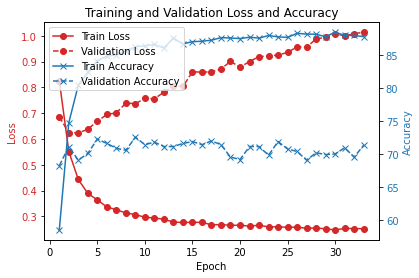

In [47]:
train1.pic(train1.trainloss, train1.trainacc, train1.validloss, train1.validacc)

In [ ]:
model_IT = EarlyFusionModel(text_dim=text_len, metadata_dim=meta_len, output_dim=3,
                         use_images=True, use_text=True, use_metadata=False)
model_IT=nn.DataParallel(model_IT)
train2=Train(train_loader, test_loader)

trained_IT=train2.train(model_IT, epochs_num, patience, lr=0.001)

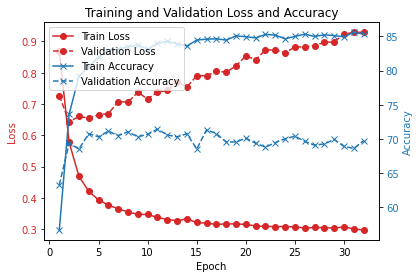

In [35]:
train2.pic(train2.trainloss, train2.trainacc, train2.validloss, train2.validacc)

In [ ]:
model_IM = EarlyFusionModel(text_dim=text_len, metadata_dim=meta_len, output_dim=3,
                         use_images=True, use_text=False, use_metadata=True)
model_IM=nn.DataParallel(model_IM)
train3=Train(train_loader, test_loader)

trained_IM=train3.train(model_IM, epochs_num, patience, lr=0.001)

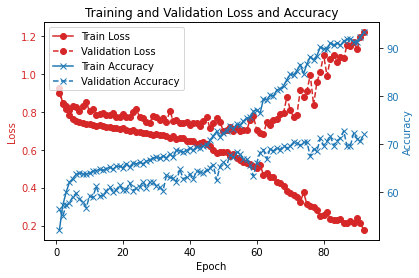

In [36]:
train3.pic(train3.trainloss, train3.trainacc, train3.validloss, train3.validacc)

In [39]:
torch.save(trained_ITM, 'model_ITM.pth')
torch.save(trained_IT, 'model_IT.pth')
torch.save(trained_IM, 'model_IM.pth')

### 更复杂

In [44]:

class EarlyFusionModel_Complx(nn.Module):
    def __init__(self, text_dim, metadata_dim, output_dim, use_images=True, use_text=True, use_metadata=True):
        super(EarlyFusionModel_Complx, self).__init__()
        self.use_images = use_images
        self.use_text = use_text
        self.use_metadata = use_metadata
        
        # 图像特征提取器
        if self.use_images:
            self.squeezenet_main = models.squeezenet1_1(pretrained=True)
            self.squeezenet_aux1 = models.squeezenet1_1(pretrained=True)
            self.squeezenet_aux2 = models.squeezenet1_1(pretrained=True)

            # 替换分类器以匹配我们的输出维度

            self.squeezenet_main.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 256, kernel_size=1),  # 输出特征向量尺寸为256
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)  # 全局平均池化
            )

            self.squeezenet_aux1.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
            self.squeezenet_aux2.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1)
            )
    
        if self.use_text:
        # 全连接层处理文本和元数据
            self.fc_text = nn.Linear(text_dim, 512)
            
        if self.use_metadata:
            self.fc_metadata = nn.Linear(metadata_dim, 512)

        # 分类器
        combined_dim = (128*4 if use_images else 0) + (512 if use_text else 0) + (512 if use_metadata else 0)
        self.classifier = nn.Linear(combined_dim, output_dim)

    def forward(self, images_main, images_aux1, images_aux2, text_features, metadata_features):
        features_combined = []

        # 处理图像特征
        if self.use_images:
            features_main = self.squeezenet_main(images_main)
            features_aux1 = self.squeezenet_aux1(images_aux1)
            features_aux2 = self.squeezenet_aux2(images_aux2)

            
            # 展平特征
            features_main = torch.flatten(features_main, 1)
            features_aux1 = torch.flatten(features_aux1, 1)
            features_aux2 = torch.flatten(features_aux2, 1)
            

            
            # 合并特征
            features_combined.append(features_main)
            features_combined.append(features_aux1)
            features_combined.append(features_aux2)


        # 处理文本特征
        if self.use_text:
            features_text = self.fc_text(text_features)
            features_text = features_text.squeeze()
            features_combined.append(features_text)
 
        # 处理元数据特征
        if self.use_metadata:
            features_metadata = self.fc_metadata(metadata_features)
            features_combined.append(features_metadata)


        # 拼接所有特征

        features_combined = torch.cat(features_combined, dim=1)

        # 分类
        output = self.classifier(features_combined)
        return output

In [ ]:
model_ITM_Complx = EarlyFusionModel_Complx(text_dim=text_len, metadata_dim=meta_len, output_dim=3,
                         use_images=True, use_text=True, use_metadata=True)
model_ITM_Complx=nn.DataParallel(model_ITM_Complx)
train1_cplx=Train(train_loader, test_loader)
model_ITM_Complx=train1_cplx.train(model_ITM_Complx, epochs_num, patience, lr=0.001)

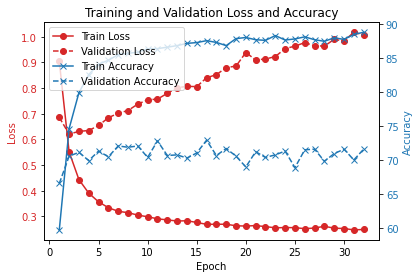

In [50]:
train1_cplx.pic(train1_cplx.trainloss, train1_cplx.trainacc, train1_cplx.validloss, train1_cplx.validacc)

In [ ]:
model_IM_Complx = EarlyFusionModel_Complx(text_dim=text_len, metadata_dim=meta_len, output_dim=3,
                         use_images=True, use_text=False, use_metadata=True)
model_IM_Complx=nn.DataParallel(model_IM_Complx)
train3_Complx=Train(train_loader, test_loader)

trained_IM_Complx=train3_Complx.train(model_IM_Complx, epochs_num, patience, lr=0.001)

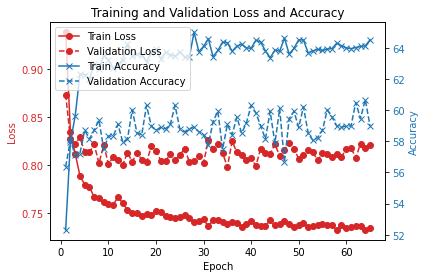

In [51]:
train3_Complx.pic(train3_Complx.trainloss, train3_Complx.trainacc, train3_Complx.validloss, train3_Complx.validacc)


transformer

### 晚期融合

In [104]:
class Train_aux_pic(Train):
    def __init__(self, train_loader, test_loader,model_idx):
        super().__init__(train_loader, test_loader)
        self.model_idx=model_idx
    def train_step(self, model, criterion, optimizer, batch_data):
        """执行一个训练步骤"""
        # 将所有数据移动到指定设备（GPU或CPU）
        labels = batch_data['label'].to(self.device)
        
        if self.model_idx=='meta':     
            metadata = batch_data['metadata'].to(self.device)
            optimizer.zero_grad()
            outputs = model(metadata)
            
            
        elif self.model_idx=='text':
            text_data = batch_data['text'].to(self.device)
            optimizer.zero_grad()
            outputs = model(text_data)
        
        else:
            detailed_images=[[],[]]
            for data in batch_data['detailed_img']:
                detailed_images[0].append(data[0].to(self.device))
                detailed_images[1].append(data[1].to(self.device))

            detailed_images[0]=torch.stack(detailed_images[0])
            detailed_images[1]=torch.stack(detailed_images[1])

            optimizer.zero_grad()
            outputs = model(detailed_images[self.model_idx])
            
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        return loss.item(), outputs

    def valid_step(self, model, criterion, batch_data):
        """执行一个验证步骤"""
        # 将所有数据移动到指定设备（GPU或CPU）
        labels = batch_data['label'].to(self.device)
        if self.model_idx=='meta':     
            metadata = batch_data['metadata'].to(self.device)
            outputs = model(metadata)
            
            
        elif self.model_idx=='text':
            text_data = batch_data['text'].to(self.device)
            outputs = model(text_data)
            
        
        else:
            detailed_images=[[],[]]
            for data in batch_data['detailed_img']:
                detailed_images[0].append(data[0].to(self.device))
                detailed_images[1].append(data[1].to(self.device))

            detailed_images[0]=torch.stack(detailed_images[0])
            detailed_images[1]=torch.stack(detailed_images[1])

            # 调用模型的前向传播。假设模型的前向方法接受五个参数：
            outputs = model(detailed_images[self.model_idx])
        
        loss = criterion(outputs, labels)
        return loss.item(), outputs

In [83]:
model_mobilenet_aux1 = models.mobilenet_v2(pretrained=True)
model_mobilenet_aux2 = models.mobilenet_v2(pretrained=True)

num_classes = 3
model_mobilenet_aux1.classifier[1] = torch.nn.Linear(model_mobilenet_aux1.last_channel, num_classes)
model_mobilenet_aux2.classifier[1] = torch.nn.Linear(model_mobilenet_aux2.last_channel, num_classes)

In [ ]:
train_aux_1=Train_aux_pic(train_loader, test_loader,model_idx=0)
trained_aux_1=train_aux_1.train(model_mobilenet_aux1, epochs_num, patience, lr=0.001)

Epoch 1: Train Loss: 0.7125, Train Accuracy: 61.54%, Validation Loss: 0.7422, Validation Accuracy: 63.67%
Epoch 2: Train Loss: 0.6064, Train Accuracy: 70.16%, Validation Loss: 0.7072, Validation Accuracy: 65.92%
Epoch 3: Train Loss: 0.5429, Train Accuracy: 73.74%, Validation Loss: 0.6571, Validation Accuracy: 67.79%
Epoch 4: Train Loss: 0.4470, Train Accuracy: 79.20%, Validation Loss: 0.5812, Validation Accuracy: 69.76%
Epoch 5: Train Loss: 0.3988, Train Accuracy: 82.22%, Validation Loss: 0.6462, Validation Accuracy: 71.35%
Epoch 6: Train Loss: 0.3182, Train Accuracy: 86.88%, Validation Loss: 0.6332, Validation Accuracy: 76.50%
Epoch 7: Train Loss: 0.2729, Train Accuracy: 89.11%, Validation Loss: 0.5916, Validation Accuracy: 76.12%
Epoch 8: Train Loss: 0.2242, Train Accuracy: 91.31%, Validation Loss: 0.5986, Validation Accuracy: 79.68%
Epoch 9: Train Loss: 0.1735, Train Accuracy: 93.58%, Validation Loss: 0.8481, Validation Accuracy: 75.37%
Epoch 10: Train Loss: 0.1883, Train Accuracy: 

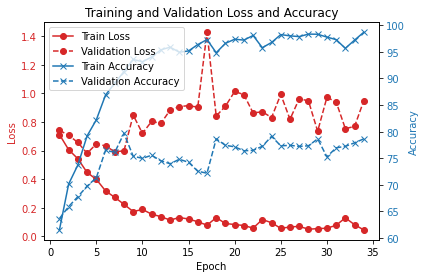

In [92]:
train_aux_1.pic(train_aux_1.trainloss, train_aux_1.trainacc, train_aux_1.validloss, train_aux_1.validacc)

In [94]:
torch.save(trained_aux_1,'trained_aux_1.pth')

In [ ]:
train_aux_2=Train_aux_pic(train_loader, test_loader,model_idx=1)
trained_aux_2=train_aux_2.train(model_mobilenet_aux2, epochs_num, patience, lr=0.001)

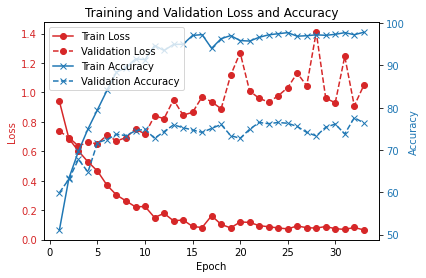

In [95]:
train_aux_2.pic(train_aux_2.trainloss, train_aux_2.trainacc, train_aux_2.validloss, train_aux_2.validacc)

In [96]:
torch.save(trained_aux_2,'trained_aux_2.pth')

### 加载文字和元数据

In [ ]:
# 加载预训练模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(MLP, self).__init__()
        # 初始化多个全连接层
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        self.dropout = nn.Dropout(0.6)  # Dropout层

    def forward(self, x):
        # 通过第一个全连接层后接ReLU激活函数
        x = F.relu(self.fc1(x))
        # 通过第二个全连接层后接ReLU激活函数
        x = F.relu(self.fc2(x))
        # 应用Dropout
        x = self.dropout(x)
        # 通过第三个全连接层后接ReLU激活函数
        x = F.relu(self.fc3(x))
        # 可以继续添加Dropout或其他正则化
        # 通过第四个全连接层后接ReLU激活函数
        # 输出层，没有激活函数，这将在损失函数中处理
        x = self.fc4(x)
        return x
    
    
class LSTMSalesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMSalesPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # 全连接层，预测销售类别
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, titles):
        if titles.dim() == 2:
            titles = titles.unsqueeze(1)  # 现在形状为 [batch_size, 1, feature_number]

        # LSTM层的初始隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)
        c0 = torch.zeros(self.num_layers, titles.size(0), self.hidden_dim).to(titles.device)

        # 前向传播LSTM
        out, _ = self.lstm(titles, (h0, c0))

        # 选择LSTM输出的最后一个时间步
        out = out[:, -1, :]

        # 全连接层
        out = self.fc(out)
        return out

Epoch 1: Train Loss: 1.0244, Train Accuracy: 40.03%, Validation Loss: 0.9456, Validation Accuracy: 50.56%
Epoch 2: Train Loss: 0.8977, Train Accuracy: 52.64%, Validation Loss: 0.8523, Validation Accuracy: 55.24%
Epoch 3: Train Loss: 0.8250, Train Accuracy: 57.60%, Validation Loss: 0.8132, Validation Accuracy: 57.12%
Epoch 4: Train Loss: 0.7676, Train Accuracy: 60.25%, Validation Loss: 0.7366, Validation Accuracy: 62.27%
Epoch 5: Train Loss: 0.7047, Train Accuracy: 64.37%, Validation Loss: 0.6964, Validation Accuracy: 64.61%
Epoch 6: Train Loss: 0.6647, Train Accuracy: 66.50%, Validation Loss: 0.6542, Validation Accuracy: 67.88%
Epoch 7: Train Loss: 0.6164, Train Accuracy: 68.80%, Validation Loss: 0.6254, Validation Accuracy: 68.07%
Epoch 8: Train Loss: 0.5877, Train Accuracy: 70.63%, Validation Loss: 0.6089, Validation Accuracy: 69.19%
Epoch 9: Train Loss: 0.5543, Train Accuracy: 72.36%, Validation Loss: 0.6083, Validation Accuracy: 69.10%
Epoch 10: Train Loss: 0.5426, Train Accuracy: 

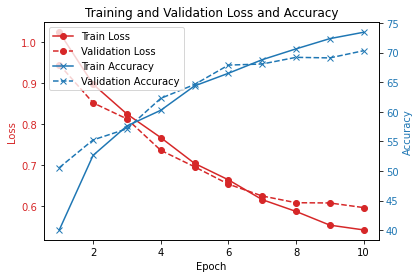

In [105]:
model_MLP=MLP(meta_len,[100,50,10],num_classes)
train_meta=Train_aux_pic(train_loader, test_loader,model_idx='meta')
trained_meta=train_meta.train(model_MLP, 10, 3, lr=0.001)

In [111]:
torch.save(trained_meta,'trained_meta.pth')

Epoch 1: Train Loss: 0.9771, Train Accuracy: 46.90%, Validation Loss: 0.8421, Validation Accuracy: 60.21%
Epoch 2: Train Loss: 0.6993, Train Accuracy: 66.60%, Validation Loss: 0.6734, Validation Accuracy: 68.16%
Epoch 3: Train Loss: 0.5382, Train Accuracy: 75.36%, Validation Loss: 0.6313, Validation Accuracy: 70.51%
Epoch 4: Train Loss: 0.4574, Train Accuracy: 79.34%, Validation Loss: 0.6355, Validation Accuracy: 69.29%
Epoch 5: Train Loss: 0.4071, Train Accuracy: 81.28%, Validation Loss: 0.6470, Validation Accuracy: 70.88%
Epoch 6: Train Loss: 0.3784, Train Accuracy: 82.92%, Validation Loss: 0.6621, Validation Accuracy: 71.91%
Epoch 6: Early stopping!


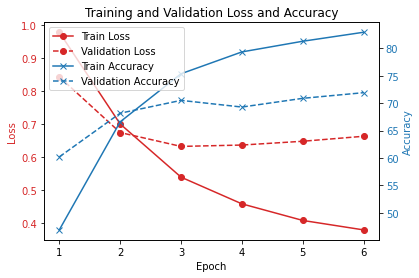

In [109]:
model_LTSM=LSTMSalesPredictor(text_len,128,2, num_classes)
train_text=Train_aux_pic(train_loader, test_loader,model_idx='text')
trained_text=train_text.train(model_LTSM, 10, 3, lr=0.001)

In [112]:
torch.save(trained_text,'trained_text.pth')

### 晚期融合

In [133]:
class LateFusionModel(nn.Module):
    def __init__(self, model_text, model_meta, model_image, model_aux1, model_aux2):
        super(LateFusionModel, self).__init__()
        # 存储预训练模型
        self.device="cuda"
        self.model_text = model_text.to(self.device)
        self.model_meta = model_meta.to(self.device)
        self.model_image = model_image.to(self.device)
        self.model_aux1 = model_aux1.to(self.device)
        self.model_aux2 = model_aux2.to(self.device)

        # 确保预训练模型处于评估模式
        self.model_text.eval()
        self.model_meta.eval()
        self.model_image.eval()
        self.model_aux1.eval()
        self.model_aux2.eval()

        # 不需要计算梯度
        for model in [self.model_text, self.model_meta, self.model_image, self.model_aux1, self.model_aux2]:
            for param in model.parameters():
                param.requires_grad = False

    def forward(self,  image_data, aux_data1, aux_data2,text_data, meta_data):
        #model(images, detailed_images[0], detailed_images[1], text_data, metadata)
        with torch.no_grad():
            preds_text = self.model_text(text_data).argmax(dim=1)
            preds_meta = self.model_meta(meta_data).argmax(dim=1)
            preds_image = self.model_image(image_data).argmax(dim=1)
            preds_aux1 = self.model_aux1(aux_data1).argmax(dim=1)
            preds_aux2 = self.model_aux2(aux_data2).argmax(dim=1)

        # 应用改进的投票规则
        batch_size = preds_text.size(0)
        final_preds = torch.zeros(batch_size, dtype=torch.long)
        for i in range(batch_size):
            # 统计票数
            votes = {}
            for pred in [preds_text[i], preds_meta[i], preds_image[i]]:
                votes[pred.item()] = votes.get(pred.item(), 0) + 1
            for pred in [preds_aux1[i], preds_aux2[i]]:
                votes[pred.item()] = votes.get(pred.item(), 0) + 0.5*2

            # 多数表决
            final_preds[i] = max(votes, key=votes.get)

        return final_preds


In [113]:
'''
model_text = torch.load('model_Descrip_aug.pth')
model_meta = torch.load('model2_meta.pth')
model_image = torch.load('model11.pth')
'''
model_image = torch.load('model11.pth')

In [134]:

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # 将模型设置为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 关闭梯度计算
        for batch_data in data_loader:
            # 获取输入数据和标签，并移动到设备上
            images = batch_data['image'].to(device)
            text_data = batch_data['text'].to(device)
            metadata = batch_data['metadata'].to(device)
            labels = batch_data['label'].to(device)
            detailed_images=[[],[]]
            for data in batch_data['detailed_img']:
                detailed_images[0].append(data[0].to(device))
                detailed_images[1].append(data[1].to(device))

            detailed_images[0]=torch.stack(detailed_images[0])
            detailed_images[1]=torch.stack(detailed_images[1])

            # 调用模型的前向传播。假设模型的前向方法接受五个参数：
            outputs = model(images, detailed_images[0], detailed_images[1], text_data, metadata)

            # 计算准确率
            if outputs.dim() > 1:  # 如果是二维输出
                _, predicted = torch.max(outputs, dim=1)
            else:  # 如果输出已经是类别
                predicted = outputs
            # 确保预测和标签在同一个设备上
            predicted = predicted.to(device)
            labels = labels.to(device)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算整体准确率
    accuracy = 100 * correct / total
    return accuracy

# 创建模型实例
late_fusion_model = LateFusionModel(trained_text, trained_meta, model_image, trained_aux_1, trained_aux_2).to(device)

# 在训练集和测试集上评估模型
train_accuracy = evaluate_model(late_fusion_model, train_loader)
test_accuracy = evaluate_model(late_fusion_model, test_loader)

print(f'Train Accuracy: {train_accuracy:.4f}%')
print(f'Test Accuracy: {test_accuracy:.4f}%')


Train Accuracy: 91.6842%
Test Accuracy: 77.4345%


### 注意力机制

In [150]:
class LateFusionModelWithAttention(nn.Module):
    def __init__(self, model_text, model_meta, model_image, model_aux1, model_aux2, output_dim=3):
        super(LateFusionModelWithAttention, self).__init__()
        self.model_text = model_text
        self.model_meta = model_meta
        self.model_image = model_image
        self.model_aux1 = model_aux1
        self.model_aux2 = model_aux2
        
        

        # 注意力权重
        self.attention_weights = nn.Parameter(torch.randn(5, requires_grad=True))

        # 最终分类器
        self.fc_image = nn.Linear(1000, output_dim)
        self.classifier = nn.Linear(output_dim, output_dim)

        # 确保所有模型处于评估模式
        for model in [self.model_text, self.model_meta, self.model_image, self.model_aux1, self.model_aux2]:
            model.eval()
            for param in model.parameters():
                param.requires_grad = False

    def forward(self, image_data, aux_data1, aux_data2,text_data, meta_data):
        with torch.no_grad():
            output_text = self.model_text(text_data)
            output_meta = self.model_meta(meta_data)
            output_image = self.model_image(image_data)
            output_image=self.fc_image(output_image)
            output_aux1 = self.model_aux1(aux_data1)
            output_aux2 = self.model_aux2(aux_data2)

        # 将不同模型的输出堆叠起来
        #print(output_text.shape,output_meta.shape, output_image.shape, output_aux1.shape, output_aux2.shape)
        outputs = torch.stack([output_text, output_meta, output_image, output_aux1, output_aux2], dim=1)
        

        # 应用 softmax 获取注意力分数
        attention_scores = F.softmax(self.attention_weights, dim=0)


        # 加权平均
        #weighted_outputs = torch.einsum('bmd,d->bm', outputs, attention_scores)
        attention_scores = attention_scores.unsqueeze(0).unsqueeze(-1)  # 将形状从 [5] 转换为 [1, 5, 1]

        # 广播并乘以注意力分数
        weighted_outputs = outputs * attention_scores  # 结果形状将是 [batch_size, 5, output_dim]

        # 现在，对第二维（模型输出）求和，以获得加权平均
        weighted_outputs = weighted_outputs.sum(dim=1)

        # 最终分类
        final_output = self.classifier(weighted_outputs)
        return final_output

Epoch 1: Train Loss: 1.6064, Train Accuracy: 42.02%, Validation Loss: 1.2182, Validation Accuracy: 41.57%
Epoch 2: Train Loss: 0.9275, Train Accuracy: 52.31%, Validation Loss: 0.8954, Validation Accuracy: 58.90%
Epoch 3: Train Loss: 0.7510, Train Accuracy: 67.88%, Validation Loss: 0.8109, Validation Accuracy: 59.46%
Epoch 4: Train Loss: 0.6631, Train Accuracy: 70.11%, Validation Loss: 0.7557, Validation Accuracy: 61.52%
Epoch 5: Train Loss: 0.5781, Train Accuracy: 74.70%, Validation Loss: 0.6871, Validation Accuracy: 67.32%
Epoch 6: Train Loss: 0.4803, Train Accuracy: 79.97%, Validation Loss: 0.6121, Validation Accuracy: 71.16%
Epoch 7: Train Loss: 0.3808, Train Accuracy: 85.85%, Validation Loss: 0.5636, Validation Accuracy: 74.63%
Epoch 8: Train Loss: 0.2896, Train Accuracy: 90.61%, Validation Loss: 0.5243, Validation Accuracy: 78.00%
Epoch 9: Train Loss: 0.2185, Train Accuracy: 94.07%, Validation Loss: 0.5217, Validation Accuracy: 78.28%
Epoch 10: Train Loss: 0.1710, Train Accuracy: 

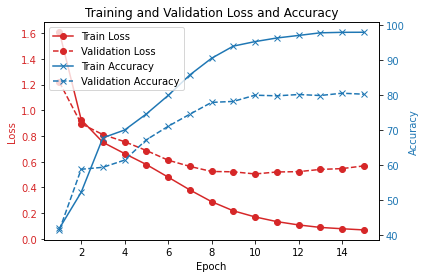

In [151]:
late_fusion_model_AT = LateFusionModelWithAttention(trained_text, trained_meta, model_image, trained_aux_1, trained_aux_2)
#late_fusion_model_AT=nn.DataParallel(late_fusion_model_AT)
train_late_AT=Train(train_loader, test_loader)
trained_late_AT=train_late_AT.train(late_fusion_model_AT, 50, 5, lr=0.001)

In [152]:
torch.save(trained_late_AT,'trained_late_AT.pth')

In [172]:
from sklearn.metrics import confusion_matrix
def evaluate_model_AT(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # 将模型设置为评估模式

    # 用于存储预测和实际标签
    all_preds = []
    all_labels = []

    with torch.no_grad():  # 关闭梯度计算
        for batch_data in data_loader:
            # 获取输入数据和标签，并移动到设备上
            images = batch_data['image'].to(device)
            text_data = batch_data['text'].to(device)
            metadata = batch_data['metadata'].to(device)
            labels = batch_data['label'].to(device)
            detailed_images=[[],[]]
            for data in batch_data['detailed_img']:
                detailed_images[0].append(data[0].to(device))
                detailed_images[1].append(data[1].to(device))

            detailed_images[0]=torch.stack(detailed_images[0])
            detailed_images[1]=torch.stack(detailed_images[1])

            # 调用模型的前向传播
            outputs = model(images, detailed_images[0], detailed_images[1], text_data, metadata)

            # 获取预测结果
            if outputs.dim() > 1:  # 如果是二维输出
                _, predicted = torch.max(outputs, dim=1)
            else:  # 如果输出已经是类别
                predicted = outputs
            
            # 收集预测和实际标签
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)

    # 计算每个单元格的百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.nan_to_num(cm_percent)  # 避免除以零产生的nan

    # 将百分比和数量结合为一个新的标签
    cm_labels = (np.asarray(["{0}\n{1:.2%}".format(num, perc)
                             for num, perc in zip(cm.flatten(), cm_percent.flatten())])
                 ).reshape(cm.shape)

    # 可视化混淆矩阵
    labels = ['High', 'Mid', 'Small']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()

    # 计算整体准确率
    total = len(all_labels)
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    accuracy = 100 * correct / total
    return accuracy

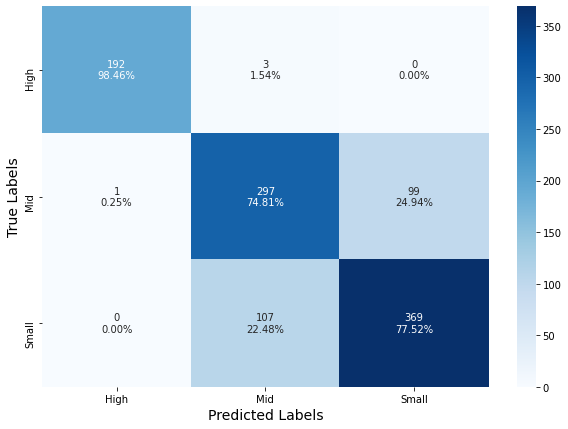

In [173]:
evaluate_model_AT(trained_late_AT, test_loader)

In [180]:
print(trained_late_AT)

LateFusionModelWithAttention(
  (model_text): LSTMSalesPredictor(
    (lstm): LSTM(1914, 128, num_layers=2, batch_first=True)
    (fc): Linear(in_features=128, out_features=3, bias=True)
  )
  (model_meta): MLP(
    (fc1): Linear(in_features=206, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=10, bias=True)
    (fc4): Linear(in_features=10, out_features=3, bias=True)
    (dropout): Dropout(p=0.6, inplace=False)
  )
  (model_image): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)


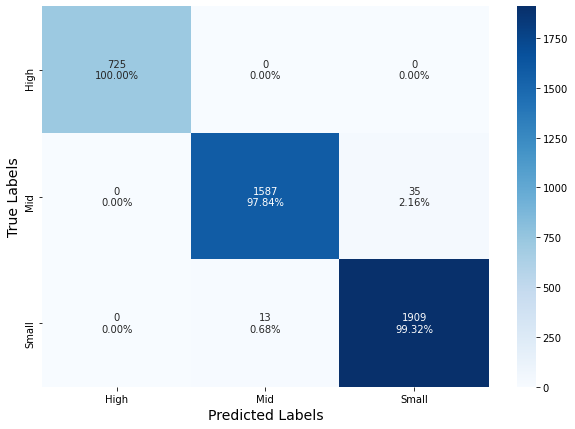

98.8756148981026

In [168]:
evaluate_model_AT(trained_late_AT, train_loader)